In [7]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from custom_datasets import dataset
from custom_models import models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

wandb_api.login()
api = wandb.Api()
run_name = "32mvu590"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
config["batch_size"] = 16
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [13]:
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
root_path = Path("tmp/")

model_script = run.file("model_script.txt")
model_script = model_script.download(root=root_path / run.name, replace=True)
model_script.seek(0)

datamodule_script = run.file("datamodule_script.txt")
datamodule_script = datamodule_script.download(root=root_path / run.name, replace=True)
datamodule_script.seek(0)

checkpoint = run.file("epoch=239-val_loss=0.076.ckpt")
checkpoint.download(root=root_path / run.name, replace=True)

model_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", model_script.read())[0]
model_script.seek(0)
datamodule_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", datamodule_script.read())[
    0
]
datamodule_script.seek(0)
with open(model_script.name, "r") as file:
    exec(file.read())
with open(datamodule_script.name, "r") as file:
    exec(file.read())


In [14]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        repo_path,
        train_df=None,
        test_df=None,
        train_dataset=None,
        validation_dataset=None,
    ):
        super().__init__()
        self.config = config
        self.repo_path = repo_path
        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if test_df is not None else None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset

        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at = wandb.Api().artifact(
                    "matiasetcheverry/microstructure-reconstruction/train_df:10_images"
                )
            if self.test_df is None:
                self.test_data_at = wandb.Api().artifact(
                    "matiasetcheverry/microstructure-reconstruction/test_df:10_images"
                )

        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(207),
                transforms.Resize(
                    (self.config["input_width"], self.config["input_width"])
                ),
                transforms.ToTensor(),
                transforms.GaussianBlur(kernel_size=3, sigma=0.5),
            ]
        )

    def prepare_data(self):
        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at.download()
            if self.test_df is None:
                self.test_data_at.download()

    def _init_df_wandb(self):
        if self.train_df is None:
            self.train_df = wandb_api.convert_table_to_dataframe(
                self.training_data_at.get("fabrics")
            )
            self.train_df["photos"] = self.train_df["photos"].apply(
                func=lambda photo_paths: [
                    str(self.repo_path / Path(x)) for x in photo_paths
                ]
            )
        if self.test_df is None:
            self.test_df = wandb_api.convert_table_to_dataframe(
                self.test_data_at.get("fabrics")
            )
            self.test_df["photos"] = self.test_df["photos"].apply(
                func=lambda photo_paths: [
                    str(self.repo_path / Path(x)) for x in photo_paths
                ]
            )

    def _init_df_local(self):
        fabrics_df = pd.read_csv(self.repo_path / "REV1_600/fabrics.txt")
        path_to_slices = self.repo_path / "REV1_600/REV1_600Slices"
        fabrics_df["photos"] = fabrics_df["id"].apply(
            func=dataframe_reformat.associate_rev_id_to_its_images,
            args=(path_to_slices, 10),
        )
        fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]
        fabrics_df["photos"] = fabrics_df["photos"].apply(func=lambda x: sorted(x))
        train_df, test_df = train_test_split(
            fabrics_df,
            train_size=config["train_val_split"],
            random_state=config["seed"],
            shuffle=True,
        )
        if self.train_df is None:
            self.train_df = train_df.reset_index(drop=True)
        if self.test_df is None:
            self.test_df = test_df.reset_index(drop=True)

    def init_df(self):
        if self.config["log_wandb"]:
            self._init_df_wandb()
        else:
            self._init_df_local()
    
    def setup(self, stage):
        if self.train_dataset is None or self.validation_dataset is None:
            self.init_df()
            self.scaler = MinMaxScaler(feature_range=(0, 1))
            self.scaler.fit_transform(self.train_df.iloc[:, 1:-1])
            self.scaler.transform(self.test_df.iloc[:, 1:-1])
            normalized_train_df = deepcopy(self.train_df)
            normalized_train_df.iloc[:, 1:-1] = self.scaler.transform(
                self.train_df.iloc[:, 1:-1]
            )
            normalized_test_df = deepcopy(self.test_df)
            normalized_test_df.iloc[:, 1:-1] = self.scaler.transform(
                self.test_df.iloc[:, 1:-1]
            )
            self.kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(
                normalized_train_df.iloc[:, 1:-1].to_numpy()
            )
            if self.train_dataset is None:
                self.train_dataset = NChannelPhotosDataset(
                    normalized_train_df, nb_input_photos_per_plane=1, transform=self.transform, noise=config["frac_noise"]
                )
            if self.validation_dataset is None:
                self.validation_dataset = NChannelPhotosDataset(
                    normalized_test_df, nb_input_photos_per_plane=1, transform=self.transform, noise=0
                )
            self.targets = self.test_df.iloc[:, 1:-1].to_numpy()

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.config["batch_size"],
            shuffle=True,
            **kwargs,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation_dataset,
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(
            [image for image, _ in self.validation_dataset],
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )


In [15]:
NChannelPhotosDataset = dataset.NChannelPhotosDataset

dm = DataModule(config=config, repo_path=repo_path)
model = eval(model_name).load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer = pl.Trainer(devices="auto", accelerator="auto")
predictions = torch.cat(trainer.predict(model, datamodule=dm))
targets = torch.cat([label for _, label in dm.val_dataloader()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(dm.train_df.iloc[:, 1:-1])
scaler.transform(dm.test_df.iloc[:, 1:-1])
normalized_train_df = deepcopy(dm.train_df)
normalized_train_df.iloc[:, 1:-1] = scaler.transform(
    dm.train_df.iloc[:, 1:-1]
)
normalized_test_df = deepcopy(dm.test_df)
normalized_test_df.iloc[:, 1:-1] = scaler.transform(
    dm.test_df.iloc[:, 1:-1]
)


validation_dataset_random_order = NChannelPhotosDataset(
    normalized_test_df, nb_input_photos_per_plane=1, transform=dm.transform, noise=0, order="random"
)
validation_dataset_yzx_order = NChannelPhotosDataset(
    normalized_test_df, nb_input_photos_per_plane=1, transform=dm.transform, noise=0, order="yzx"
)


dm_random_order = DataModule(config, repo_path, validation_dataset=validation_dataset_random_order)
model_random_order = eval(model_name).load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer_random_order = pl.Trainer(devices="auto", accelerator="auto")
predictions_random_order = torch.cat(trainer_random_order.predict(model_random_order, datamodule=dm_random_order))
targets_random_order = torch.cat([label for _, label in dm_random_order.val_dataloader()])


dm_yzx_order = DataModule(config, repo_path, validation_dataset=validation_dataset_yzx_order)
model_yzx_order = eval(model_name).load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer_yzx_order = pl.Trainer(devices="auto", accelerator="auto")
predictions_yzx_order = torch.cat(trainer_yzx_order.predict(model_yzx_order, datamodule=dm_yzx_order))
targets_yzx_order = torch.cat([label for _, label in dm_yzx_order.val_dataloader()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

In [17]:
print("VALIDATION ON 'XYZ' ORDER")
print(
    f"COSINE SIMILARITY: {torchmetrics.CosineSimilarity(reduction='mean')(predictions, targets)}"
)
print(f"R2 SCORE: {torchmetrics.R2Score(num_outputs=23)(predictions, targets)}")
print(
    f"SMAPE: {torchmetrics.SymmetricMeanAbsolutePercentageError()(predictions, targets)}"
)
print(f"MAPE: {torchmetrics.MeanAbsolutePercentageError()(predictions, targets)}")
print(f"MAE: {torchmetrics.MeanAbsoluteError()(predictions, targets)}")
print(f"LOSS: {nn.L1Loss()(predictions, targets)}")
print("_______________________________________________________________")

print("VALIDATION ON YZX ORDER")
print(
    f"COSINE SIMILARITY: {torchmetrics.CosineSimilarity(reduction='mean')(predictions_yzx_order, targets_yzx_order)}"
)
print(f"R2 SCORE: {torchmetrics.R2Score(num_outputs=23)(predictions_yzx_order, targets_yzx_order)}")
print(
    f"SMAPE: {torchmetrics.SymmetricMeanAbsolutePercentageError()(predictions_yzx_order, targets_yzx_order)}"
)
print(f"MAPE: {torchmetrics.MeanAbsolutePercentageError()(predictions_yzx_order, targets_yzx_order)}")
print(f"MAE: {torchmetrics.MeanAbsoluteError()(predictions_yzx_order, targets_yzx_order)}")
print(f"LOSS: {nn.L1Loss()(predictions_yzx_order, targets_yzx_order)}")
print("_______________________________________________________________")


print("VALIDATION ON RANDOM ORDER")
print(
    f"COSINE SIMILARITY: {torchmetrics.CosineSimilarity(reduction='mean')(predictions_random_order, targets_random_order)}"
)
print(f"R2 SCORE: {torchmetrics.R2Score(num_outputs=23)(predictions_random_order, targets_random_order)}")
print(
    f"SMAPE: {torchmetrics.SymmetricMeanAbsolutePercentageError()(predictions_random_order, targets_random_order)}"
)
print(f"MAPE: {torchmetrics.MeanAbsolutePercentageError()(predictions_random_order, targets_random_order)}")
print(f"MAE: {torchmetrics.MeanAbsoluteError()(predictions_random_order, targets_random_order)}")
print(f"LOSS: {nn.L1Loss()(predictions_random_order, targets_random_order)}")



VALIDATION ON 'XYZ' ORDER
COSINE SIMILARITY: 0.9816897511482239
R2 SCORE: 0.6855598092079163
SMAPE: 0.2215285301208496
MAPE: 0.6560657024383545
MAE: 0.07619012147188187
LOSS: 0.07619012147188187
_______________________________________________________________
VALIDATION ON YZX ORDER
COSINE SIMILARITY: 0.9486767649650574
R2 SCORE: 0.4065406620502472
SMAPE: 0.2943563163280487
MAPE: 1.8896455764770508
MAE: 0.11268796771764755
LOSS: 0.11268796771764755
_______________________________________________________________
VALIDATION ON RANDOM ORDER
COSINE SIMILARITY: 0.9620372653007507
R2 SCORE: 0.520198404788971
SMAPE: 0.2641715407371521
MAPE: 1.5189660787582397
MAE: 0.09785949438810349
LOSS: 0.09785949438810349


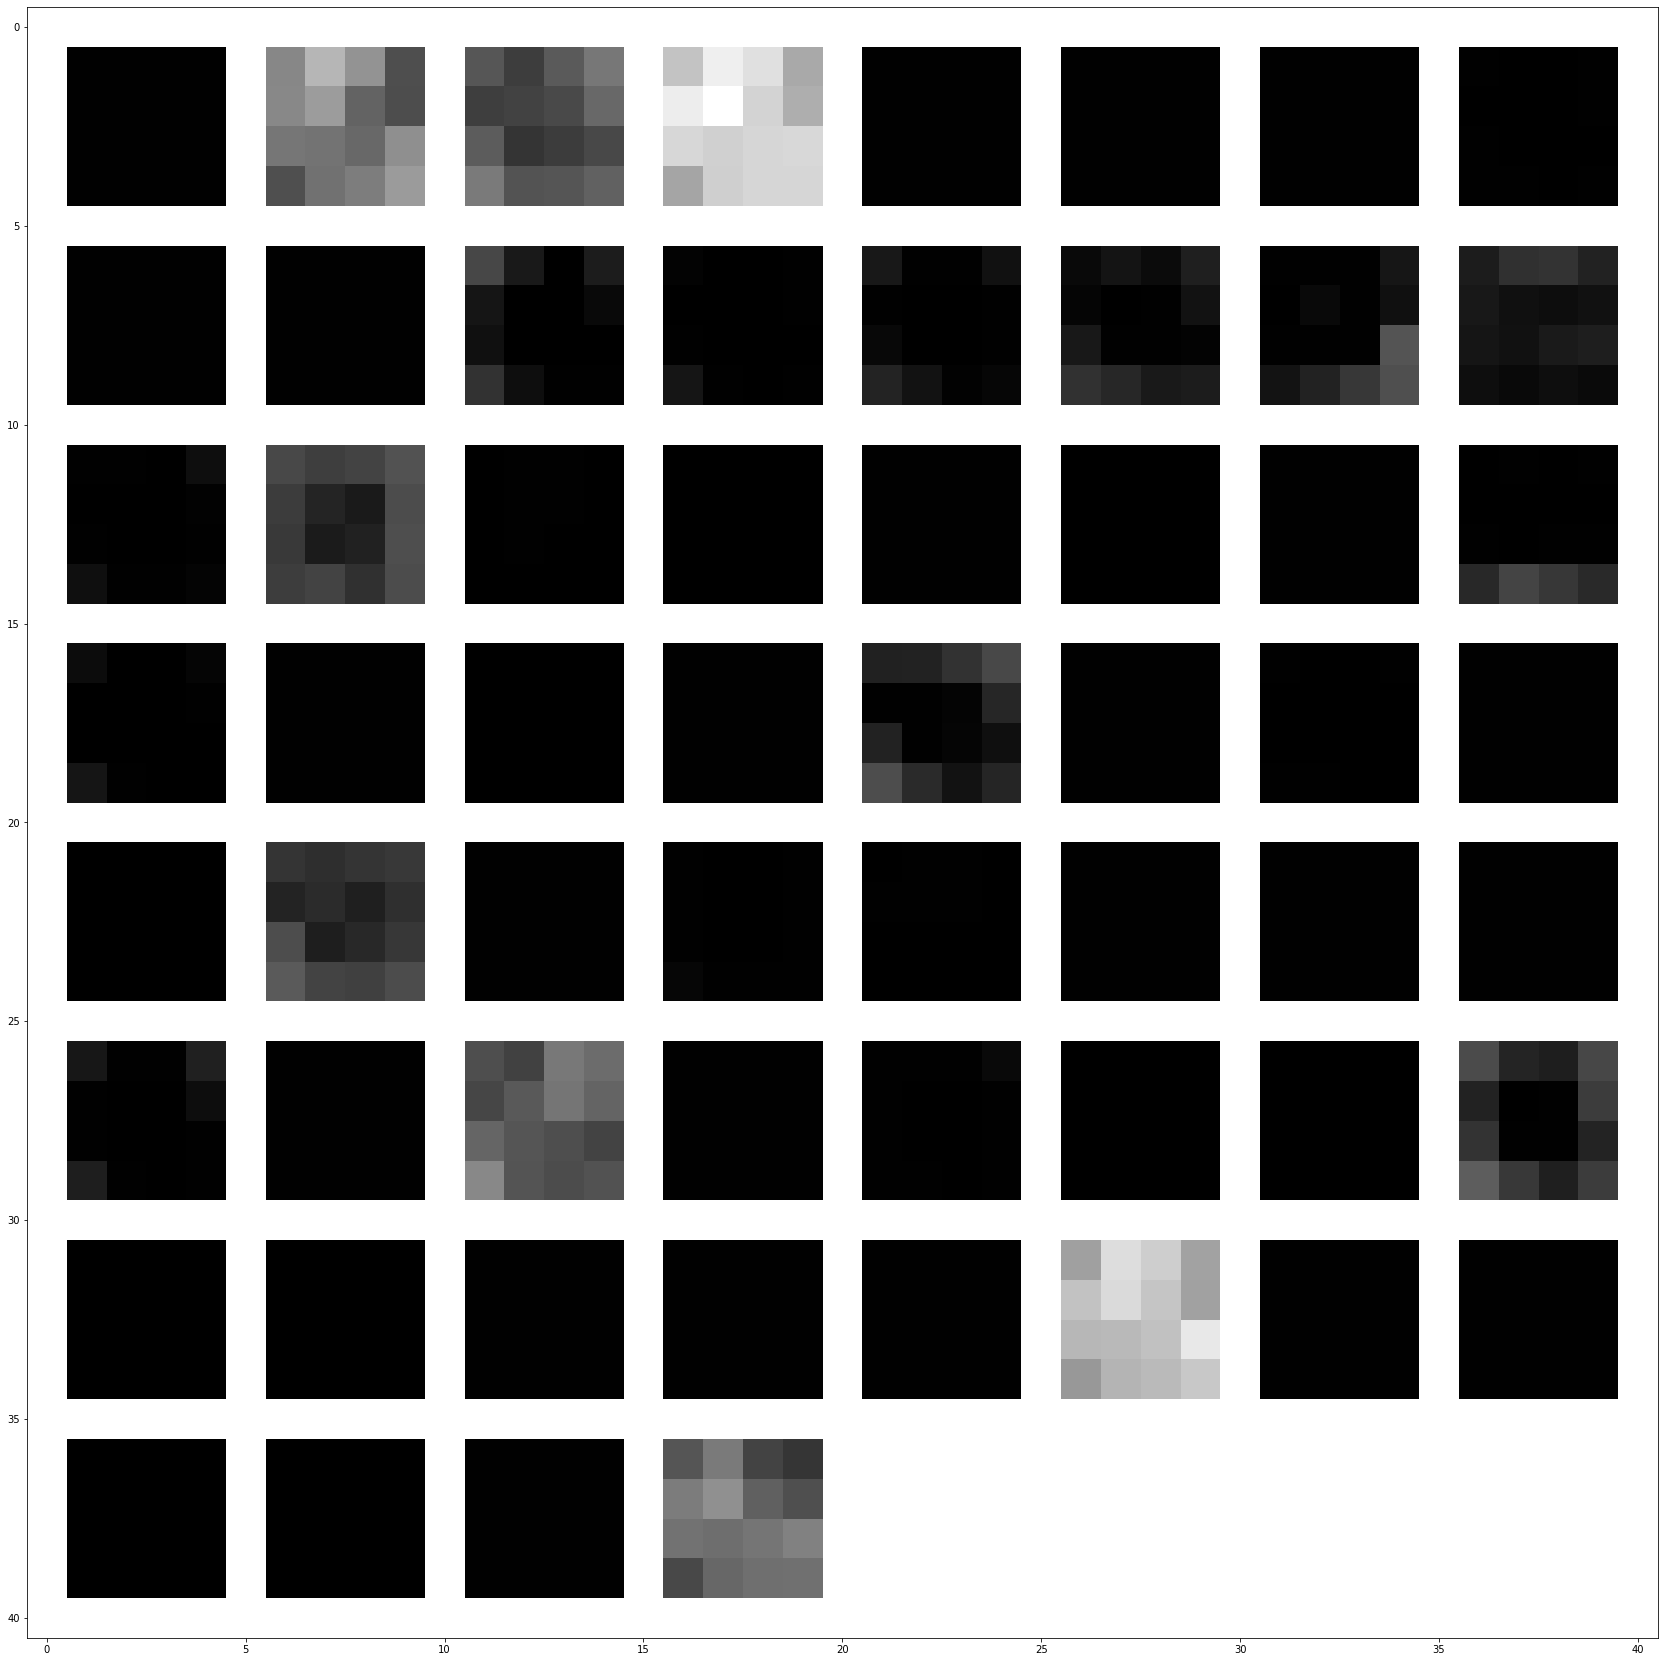

In [18]:
save_output = training.SaveOutput()
handle = model.layers[15].register_forward_hook(save_output)
images, labels = next(iter(dm.val_dataloader()))
image = images[0]
model(image.unsqueeze(0))
handle.remove()
outputs = save_output.outputs[0].permute(1, 0, 2, 3).detach().cpu()[:60]
grid_img = utils.make_grid(outputs, normalize=True, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


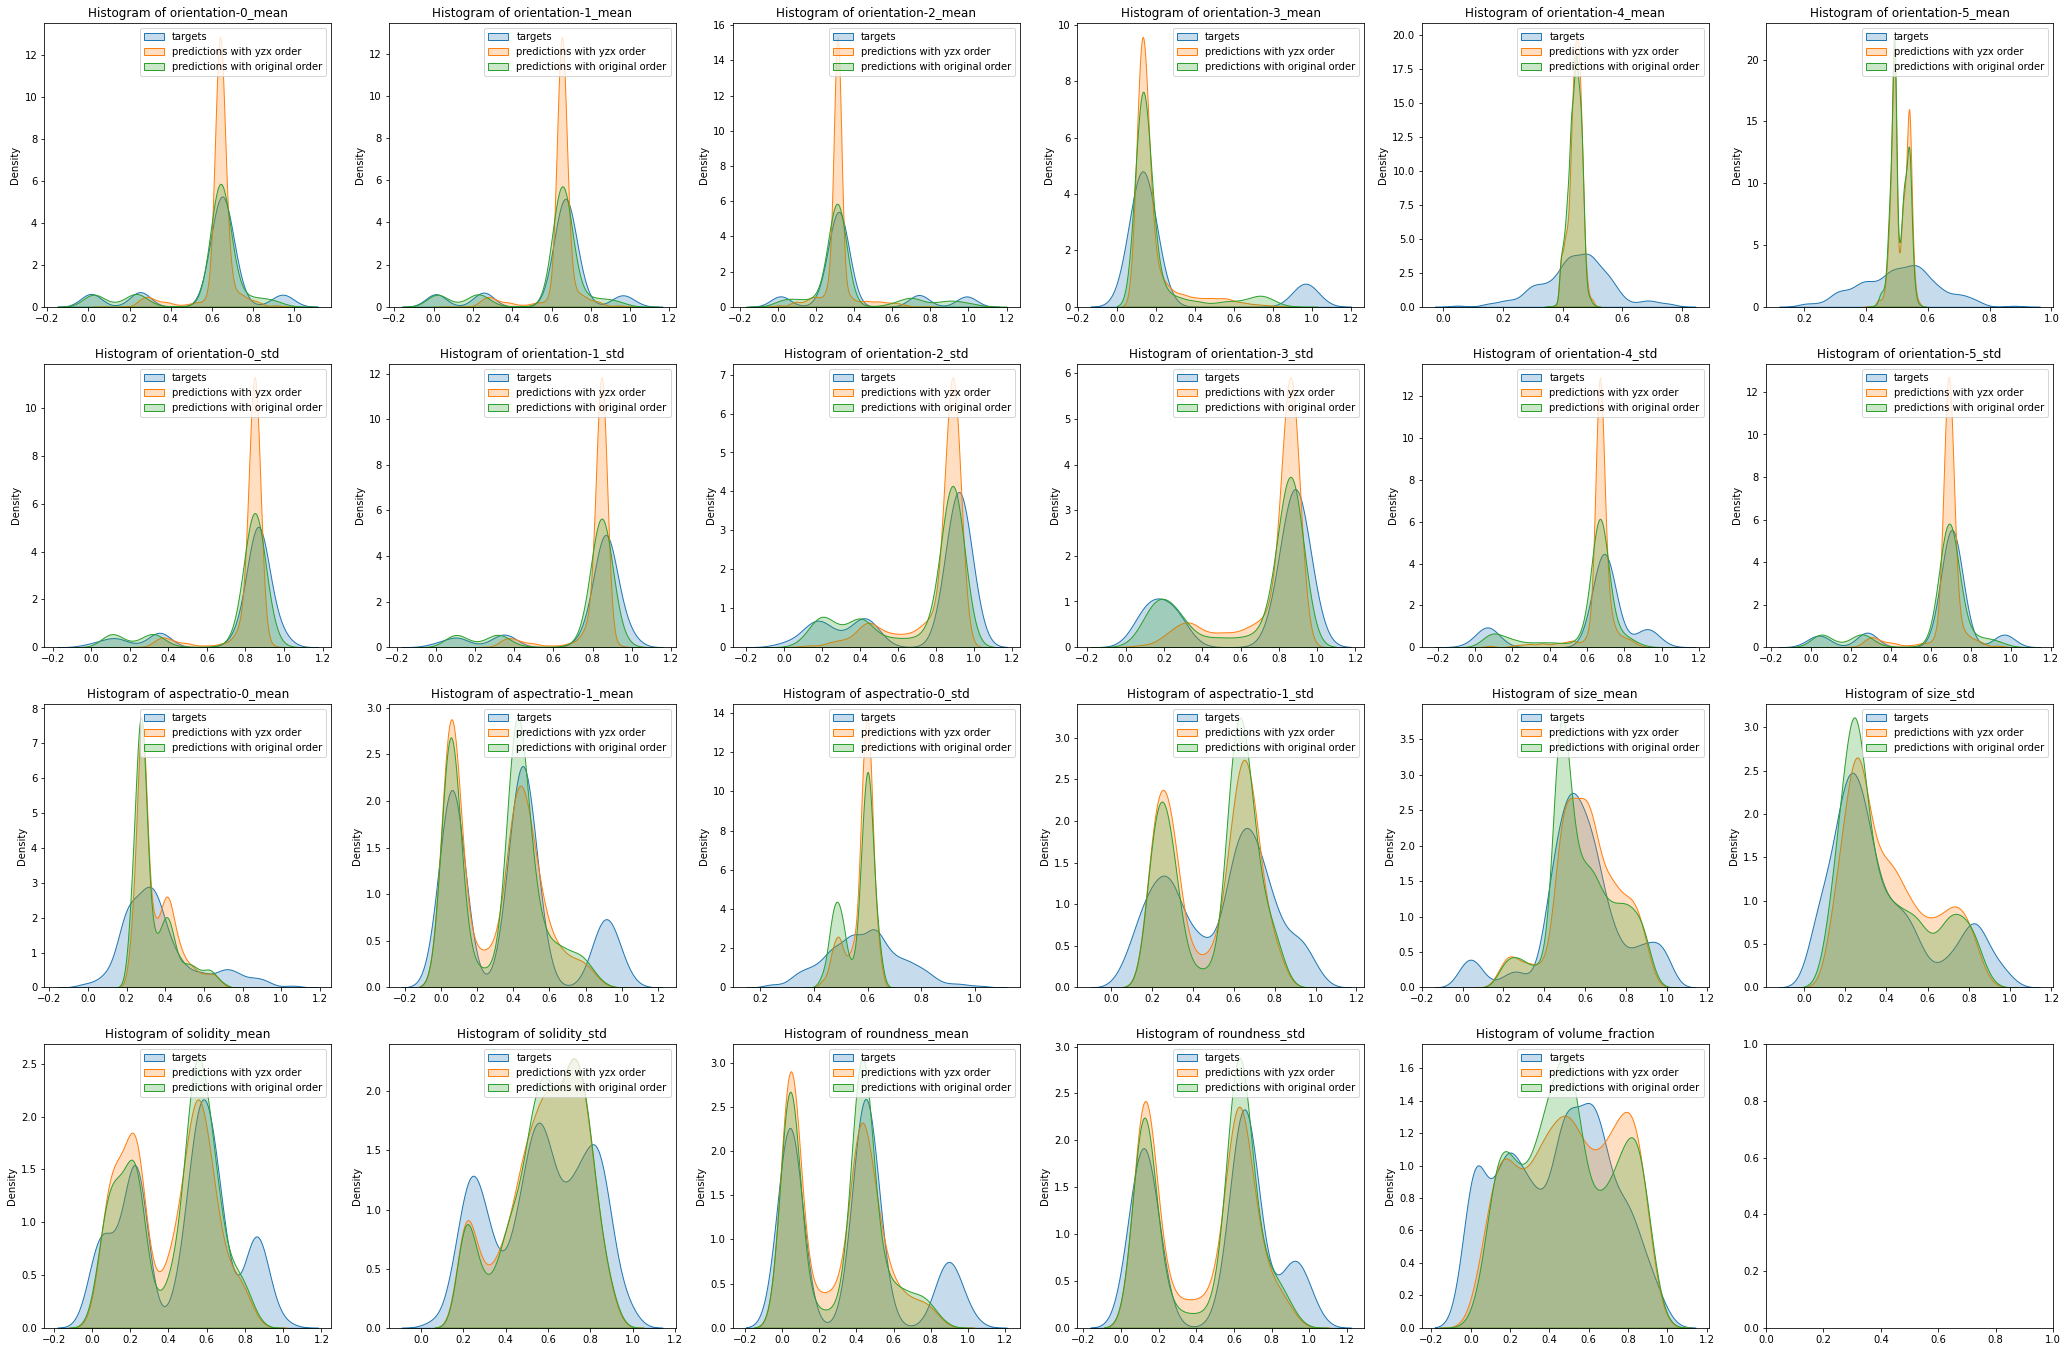

In [19]:
fig = plotting.plot_kde(
    [targets.cpu().numpy(), predictions_yzx_order.cpu().numpy(), predictions.cpu().numpy()],
    nb_hist_per_line=6,
    columns=dm.train_df.columns[1:-1],
    labels=["targets", "predictions with yzx order", "predictions with original order"],
)


<AxesSubplot:>

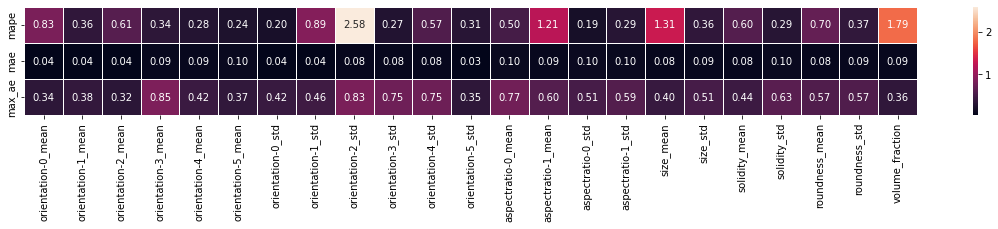

In [20]:
mae = torch.mean(torch.abs(predictions - targets), axis=0)
mape = torch.mean(torch.abs((predictions - targets) / targets), axis=0)
max_ae = torch.max(torch.abs(predictions - targets), axis=0).values

data = pd.DataFrame.from_dict(
    {"mape": mape, "mae": mae, "max_ae": max_ae},
    columns=dm.train_df.columns[1:-1],
    dtype=float,
    orient="index",
)

fig = plt.figure(figsize=(20, 2))
sns.heatmap(
    data,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)


<Figure size 7200x7200 with 0 Axes>

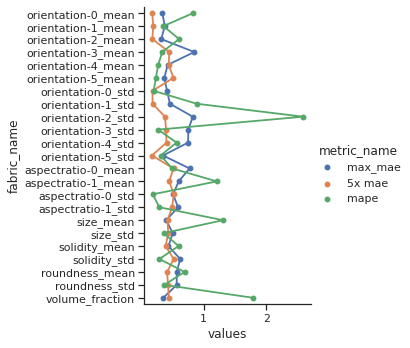

In [21]:
mae_df = pd.DataFrame(5*mae, columns=["values"])
mae_df["metric_name"] = "5x mae"
mae_df["fabric_name"] = dm.train_df.columns[1:-1]
mape_df = pd.DataFrame(mape, columns=["values"])
mape_df["metric_name"] = "mape"
mape_df["fabric_name"] = dm.train_df.columns[1:-1]
max_ae_df = pd.DataFrame(max_ae, columns=["values"])
max_ae_df["metric_name"] = "max_mae"
max_ae_df["fabric_name"] = dm.train_df.columns[1:-1]

data = pd.concat([max_ae_df, mae_df, mape_df])
fig = plt.figure(figsize=(100, 100))
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.catplot(data=data, y="fabric_name", x="values", hue="metric_name", kind="point")
